# Lab #4 Autoencoders with TensorFlow
---
# Student of group KA-03mp
# Sobol Artur
---

In [12]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

### Generation data in 3Dim

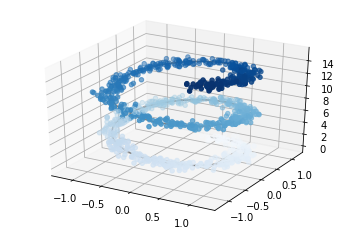

In [ ]:
ax = plt.axes ( projection ='3d')
data = np.ndarray((1024, 3))

# Data for a three - dimensional line
zline = np.linspace (0, 15, 1024)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, "gray")

# Data for three - dimensional scattered points
data[:, 2] = 15 * np.random.random(1024)
data[:, 0] = np.sin(data[:, 2]) + 0.1 * np.random.randn(1024)
data[:, 1] = np.cos(data[:, 2]) + 0.1 * np.random.randn(1024)
ax.scatter3D(data[:,0], data[:, 1], data[:, 2], c=data[:, 2], cmap ="Blues")

### Train test splitting and applying Standard Scaler

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:800])
X_test = scaler.transform(data[800:])

### Build linear Autoencoder

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=kwargs["input_shape"], out_features=2),
            nn.Linear(in_features=2, out_features=2))

        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=2),
            nn.Linear(in_features=2, out_features=kwargs["input_shape"]))
        
        self.encoder_one_dim = nn.Linear(in_features=2, out_features=1)
        self.decoder_one_dim = nn.Linear(in_features=1, out_features=2)

    def forward(self, features, one_dim=False):
        x = self.encoder(features)
        if one_dim:
            x = self.encoder_one_dim(x)
            x = self.decoder_one_dim(x)
        x = self.decoder(x)
        return x
    
    def encode(self, data):
        return self.encoder(data)
    
    def decode(self, data):
        return self.decoder(data)
    
    def encode_one_dim(self, data):
        x = self.encoder(data)
        x = self.encoder_one_dim(x)
        return x
    
    def decode_one_dim(self, data):
        x = self.decoder(data)
        x = self.decoder_one_dim(x)
        return x

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=3).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
train_tensor = torch.Tensor(X_train)
test_tensor = torch.Tensor(X_test)

train_dataset = TensorDataset(train_tensor)
test_dataset = TensorDataset(test_tensor)


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2
)

In [ ]:
epochs = 100

for epoch in range(epochs):
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 1024] matrix
        # load it to the active device
        batch_features = torch.stack(batch_features).view(-1, 3).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    if epoch % 5 == 4:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 5/100, loss = 1.082736
epoch : 10/100, loss = 0.940209
epoch : 15/100, loss = 0.798170
epoch : 20/100, loss = 0.659345
epoch : 25/100, loss = 0.552368
epoch : 30/100, loss = 0.447329
epoch : 35/100, loss = 0.373166
epoch : 40/100, loss = 0.358656
epoch : 45/100, loss = 0.357266
epoch : 50/100, loss = 0.356942
epoch : 55/100, loss = 0.356721
epoch : 60/100, loss = 0.356515
epoch : 65/100, loss = 0.356303
epoch : 70/100, loss = 0.356080
epoch : 75/100, loss = 0.355842
epoch : 80/100, loss = 0.355586
epoch : 85/100, loss = 0.355310
epoch : 90/100, loss = 0.355009
epoch : 95/100, loss = 0.354682
epoch : 100/100, loss = 0.354322


In [ ]:
output = model.encode(train_tensor)
output = output.detach().numpy()

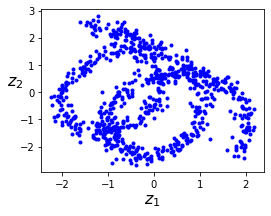

In [ ]:
fig = plt.figure(figsize=(4, 3))
plt.plot(output[:, 0], output[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16, rotation=0)
plt.show()

In [ ]:
epochs = 100
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=3).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

for epoch in range(epochs):
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 1024] matrix
        # load it to the active device
        batch_features = torch.stack(batch_features).view(-1, 3).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features, one_dim=True)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    if epoch % 5 == 4:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 5/100, loss = 1.079363
epoch : 10/100, loss = 1.020052
epoch : 15/100, loss = 0.893592
epoch : 20/100, loss = 0.713658
epoch : 25/100, loss = 0.676960
epoch : 30/100, loss = 0.669245
epoch : 35/100, loss = 0.663930
epoch : 40/100, loss = 0.659834
epoch : 45/100, loss = 0.656528
epoch : 50/100, loss = 0.653770
epoch : 55/100, loss = 0.651429
epoch : 60/100, loss = 0.649432
epoch : 65/100, loss = 0.647729
epoch : 70/100, loss = 0.646282
epoch : 75/100, loss = 0.645052
epoch : 80/100, loss = 0.644005
epoch : 85/100, loss = 0.643105
epoch : 90/100, loss = 0.642325
epoch : 95/100, loss = 0.641638
epoch : 100/100, loss = 0.641025


In [ ]:
output = model.encode_one_dim(train_tensor)
output = output.detach().numpy()
# output_3dim = np.ndarray((800,3))
# for i in range(3):
#     output_3dim[:, i] = output[:, 0]
# output = scaler.inverse_transform(output_3dim)
output[5,:]

array([1.1597419], dtype=float32)

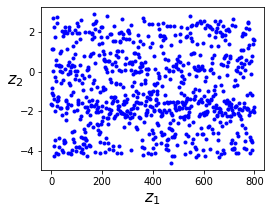

In [ ]:
fig = plt.figure(figsize=(4, 3))
plt.plot(output, "b.")
plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16, rotation=0)
plt.show()

In [ ]:
class AE_nonlinear(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=kwargs["input_shape"], out_features=2),
            nn.Linear(in_features=2, out_features=2))

        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=2),
            nn.Linear(in_features=2, out_features=kwargs["input_shape"]))
        
        self.encoder_one_dim = nn.Linear(in_features=2, out_features=1)
        self.decoder_one_dim = nn.Linear(in_features=1, out_features=2)

    def forward(self, features, one_dim=False):
        x = F.relu(self.encoder(features))
        if one_dim:
            x = F.relu(self.encoder_one_dim(x))
            x = F.relu(self.decoder_one_dim(x))
        x = torch.sigmoid(self.decoder(x))
        return x
    
    def encode(self, data):
        return self.encoder(data)
    
    def decode(self, data):
        return self.decoder(data)
    
    def encode_one_dim(self, data):
        x = self.encoder(data)
        x = self.encoder_one_dim(x)
        return x
    
    def decode_one_dim(self, data):
        x = self.decoder(data)
        x = self.decoder_one_dim(x)
        return x

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE_nonlinear(input_shape=3).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
epochs = 500

for epoch in range(1, epochs+1):
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 1024] matrix
        # load it to the active device
        batch_features = torch.stack(batch_features).view(-1, 3).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    if epoch % 50 == 0 or epoch == 1:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

epoch : 1/500, loss = 1.299275
epoch : 50/500, loss = 0.903390


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f984d394a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f984d394a70>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f984d394a70>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

epoch : 100/500, loss = 0.846516
epoch : 150/500, loss = 0.824285
epoch : 200/500, loss = 0.811515
epoch : 250/500, loss = 0.798863
epoch : 300/500, loss = 0.789993
epoch : 350/500, loss = 0.787022
epoch : 400/500, loss = 0.785948
epoch : 450/500, loss = 0.785386
epoch : 500/500, loss = 0.784999


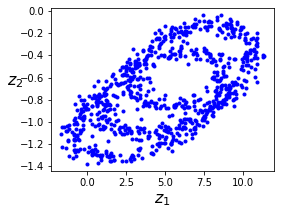

In [ ]:
output = model.encode(train_tensor)
output = output.detach().numpy()

fig = plt.figure(figsize=(4, 3))
plt.plot(output[:, 0], output[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16, rotation=0)
plt.show()

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE_nonlinear(input_shape=3).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs = 500

for epoch in range(1, epochs):
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 1024] matrix
        # load it to the active device
        batch_features = torch.stack(batch_features).view(-1, 3).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features, one_dim_model)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    if epoch % 50 == 0 or epoch == 1:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 1/500, loss = 1.271968
epoch : 50/500, loss = 0.794990
epoch : 100/500, loss = 0.776318
epoch : 150/500, loss = 0.747723
epoch : 200/500, loss = 0.744563
epoch : 250/500, loss = 0.742270
epoch : 300/500, loss = 0.740224
epoch : 350/500, loss = 0.737511
epoch : 400/500, loss = 0.733421
epoch : 450/500, loss = 0.729567


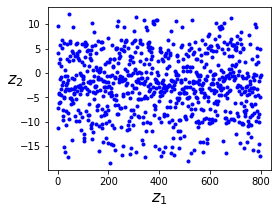

In [ ]:
output = model.encode_one_dim(train_tensor)
output = output.detach().numpy()

fig = plt.figure(figsize=(4, 3))
plt.plot(output, "b.")
plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16, rotation=0)
plt.show()

Might be better. Let's test it with bigger dataset, like a MNIST

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


In [14]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [108]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 4) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [109]:
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [110]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0519
Epoch:2, Loss:0.0410
Epoch:3, Loss:0.0350
Epoch:4, Loss:0.0324
Epoch:5, Loss:0.0370
Epoch:6, Loss:0.0268
Epoch:7, Loss:0.0283
Epoch:8, Loss:0.0302
Epoch:9, Loss:0.0322
Epoch:10, Loss:0.0304


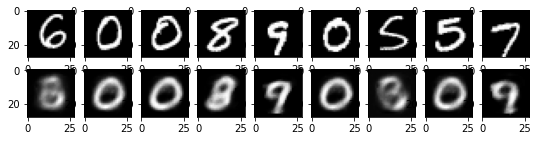

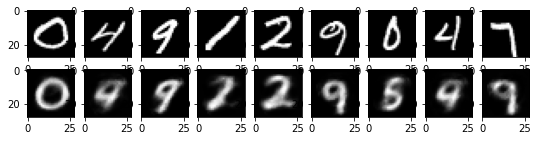

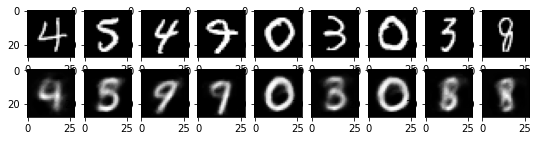

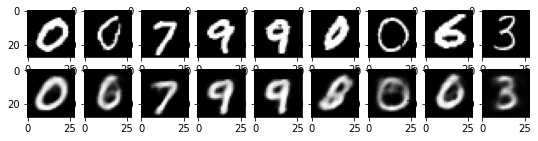

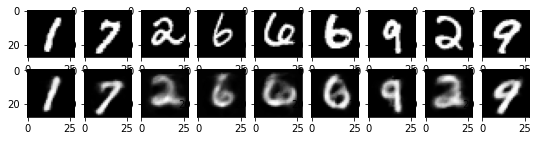

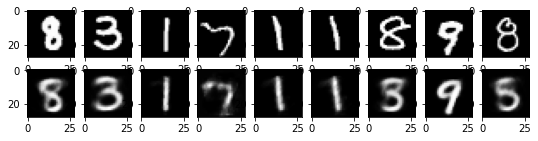

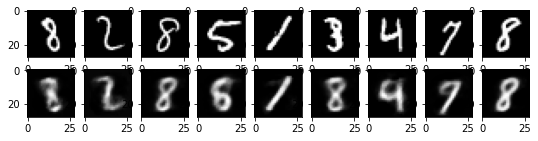

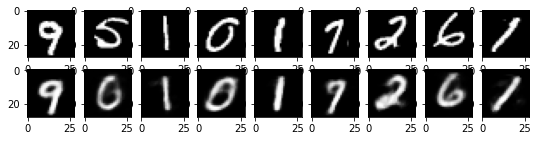

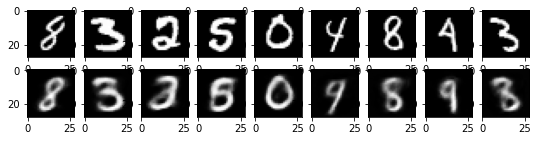

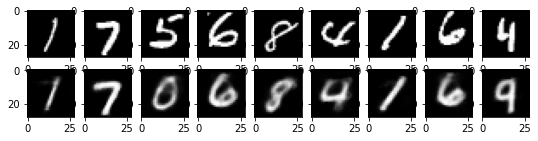

In [111]:
for k in range(0, num_epochs):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) 
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) 
        # item: 1, 28, 28
        plt.imshow(item[0])

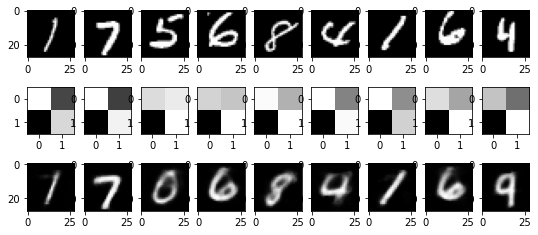

In [114]:
out_coded = []

for i, (image, _) in enumerate(data_loader):
    if i > 30:
        break
    img = img.reshape(-1, 28*28)
    coded = model.encoder(img)
    decoded = model.decoder(coded)
    out_coded.append((img, coded, decoded))

plt.figure(figsize=(9, 4))
plt.gray()
imgs = out_coded[0][0].detach().numpy()
recon = out_coded[0][1].detach().numpy()
dec = out_coded[0][2].detach().numpy()

for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(3, 9, i+1)
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(3, 9, 9+i+1) # row_length + i + 1
    item = item.reshape(-1, 2, 2)
    # item: 1, 4, 4
    plt.imshow(item[0])

for i, item in enumerate(dec):
    if i >= 9: break
    plt.subplot(3, 9, 18+i+1) # row_length + i + 1
    item = item.reshape(-1, 28, 28)
    # item: 1, 28, 28
    plt.imshow(item[0])

Ok, it's works. The previous dataset was just small to give some precision. 